## Evaluate BART Decoder

In [1]:
import sys
sys.path.append('../src')

In [2]:
import json
import os

import torch
import lightning.pytorch as pl
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

from newsgen.base_model import NewsgenBase

In [3]:
class VQVisualNewsDataset(Dataset):

    def __init__(self, visual_news_dataset_dir, split, transform):
        self.image_paths = self.get_image_paths(visual_news_dataset_dir, split)
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        sample = self.image_paths[idx]

        try:
            img = Image.open(sample[0]).convert('RGB')
            return self.transform(img), sample[1]
        except Exception as exc:
            print(exc)
            return None

    def get_image_paths(self, dataset_dir, split):
        assert split in ['train', 'val', 'test'], f'Invalid split: {split}'

        img_paths = []

        with open(os.path.join(dataset_dir, 'captions.json'), 'r') as f:
            for story in json.load(f)[split]:
                img_paths.append((os.path.join(dataset_dir, story['image_path'][2:]), story['caption']))

        return img_paths

In [4]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [5]:
test_set = VQVisualNewsDataset('../src/data/visual_news_mini', 'test', transform)
test_loader = DataLoader(test_set,
                         batch_size=4,
                         shuffle=False,
                         num_workers=0,
                         pin_memory=True)

In [23]:
test_iter = iter(test_loader)
images, captions = next(test_iter)

In [24]:
with open('../src/hparams_vqgan.json', 'r') as f:
    vqgan_hparams = json.load(f)

In [16]:
model = NewsgenBase.load_from_checkpoint('../src/pretrained/last.ckpt')
model.init_tokenizer('../src/pretrained/vqgan.ckpt', vqgan_hparams)

Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
VQLPIPSWithDiscriminator running with hinge loss.


In [25]:
encoded_text = model.tokenizer.encode_text_batch(captions)
input_ids = encoded_text['input_ids']
attention_mask = encoded_text['attention_mask']

In [26]:
model = model.to('cuda')
input_ids = input_ids.to('cuda')
attention_mask = attention_mask.to('cuda')
out = model.generate(input_ids, attention_mask)

In [27]:
out = out.cpu()
out = model.tokenizer.decode_images_code(out)

In [20]:
import torchvision
import numpy as np
import matplotlib.pyplot as plt

def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    img = np.transpose(npimg, (1, 2, 0))
    plt.imshow(img)
    if title is not None:
        plt.title(title)
    plt.axis('off')

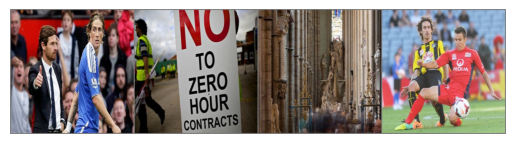

In [21]:
imshow(torchvision.utils.make_grid(images))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


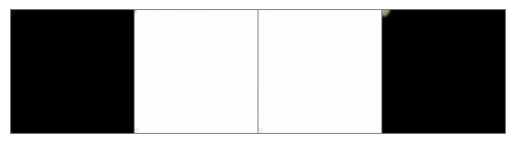

In [28]:
imshow(torchvision.utils.make_grid(out.detach()))
plt.show()